In [1]:
import os
import cv2
import time
import torch
from tqdm import tqdm
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import xml.etree.ElementTree as ET
from torch.optim import lr_scheduler
from torch.utils.data import random_split
from utils.image_utils import extract_bndbox_values
from torchvision import datasets, models, transforms

device = "cuda"

In [2]:
# Check if annotations are parsed right 
tree = ET.parse("inference-label-studio/Annotations/7c738c45-20230609_155230.xml")
root = tree.getroot()
bndbox_values = {}

for i, obj in enumerate(root.findall('object')):
    bndbox = obj.find('bndbox')
    name = obj.find('name').text

    xmin = float(bndbox.find('xmin').text)
    ymin = float(bndbox.find('ymin').text)
    xmax = float(bndbox.find('xmax').text)
    ymax = float(bndbox.find('ymax').text)
    bndbox_values[name + str(i)] = {'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax}

bndbox_values

{'spot0': {'xmin': 3292.0, 'ymin': 1850.0, 'xmax': 3528.0, 'ymax': 2008.0},
 'spot1': {'xmin': 2981.0, 'ymin': 1912.0, 'xmax': 3217.0, 'ymax': 2070.0},
 'spot2': {'xmin': 2656.0, 'ymin': 1955.0, 'xmax': 2892.0, 'ymax': 2113.0},
 'spot3': {'xmin': 2223.0, 'ymin': 1990.0, 'xmax': 2459.0, 'ymax': 2148.0},
 'spot4': {'xmin': 1847.0, 'ymin': 2025.0, 'xmax': 2083.0, 'ymax': 2183.0},
 'spot5': {'xmin': 1452.0, 'ymin': 2033.0, 'xmax': 1688.0, 'ymax': 2191.0},
 'spot6': {'xmin': 1050.0, 'ymin': 2051.0, 'xmax': 1286.0, 'ymax': 2209.0},
 'spot7': {'xmin': 601.0, 'ymin': 2081.0, 'xmax': 837.0, 'ymax': 2239.0},
 'spot8': {'xmin': 166.0, 'ymin': 2068.0, 'xmax': 402.0, 'ymax': 2226.0}}

In [3]:
# Check if images can be loaded 
image_folder = "inference-label-studio/images"
annotation_folder = "inference-label-studio/Annotations"

# Loop over images
for image_filename in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_filename)

    image_to_draw = cv2.imread(image_path)
    full_image = Image.open(image_path)
    
    print("Path: ", image_path)
    
    if image_filename.endswith(".jpg") or image_filename.endswith(".png"):
        annotation_filename = os.path.join(
            annotation_folder,
            image_filename.replace(".jpg", ".xml").replace(".png", ".xml"),
        )

    # Check if the annotation file exists
    if os.path.isfile(annotation_filename):
        bndbox_values = extract_bndbox_values(annotation_filename)

    # crop patches
    for key in bndbox_values:
            values = bndbox_values[key]
            # Extract coordinates from the bounding box
            xmin = int(values["xmin"])
            ymin = int(values["ymin"])
            xmax = int(values["xmax"])
            ymax = int(values["ymax"])
            # Crop patch for the image
            patch = full_image.crop((xmin, ymin, xmax, ymax))
            #print(patch)
            #img = Image.open(image_path)
            #display(patch)
            

Path:  inference-label-studio/images\253e1d5b-20230609_160143.jpg
Path:  inference-label-studio/images\44146dba-9b1e7b8b-20230608_110037.jpg
Path:  inference-label-studio/images\55d78e5f-20230608_105630.jpg
Path:  inference-label-studio/images\7219e6a2-pk_lot.jpg
Path:  inference-label-studio/images\7c738c45-20230609_155230.jpg
Path:  inference-label-studio/images\830075f3-20230609_160427.jpg
Path:  inference-label-studio/images\8899e45e-20230610_084906.jpg
Path:  inference-label-studio/images\8c52cc71-20230608_110040.jpg
Path:  inference-label-studio/images\92fc6ed0-692159c7-Screenshot_2023-12-14_211832.png
Path:  inference-label-studio/images\9c6ba07f-20230608_105636.jpg
Path:  inference-label-studio/images\a8ee32be-20230609_160422.jpg
Path:  inference-label-studio/images\abfaec3a-20230608_110054.jpg
Path:  inference-label-studio/images\b8759a9e-20230608_110048.jpg
Path:  inference-label-studio/images\ca8c8b20-parking.jpg
Path:  inference-label-studio/images\cf810670-20230608_110037.

In [53]:

# define datasets transformers

data_transforms = {
        "train": transforms.Compose(
            [
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        ),
        "val": transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        ),
    }


pk_lot_dir  = "pk_lot_data"
cnr_parking_dir  = "cnr_parking_data"

# load datasets
image_datasets_pk_lot = {
    x: datasets.ImageFolder(os.path.join(pk_lot_dir, y), data_transforms[y])
    for x,y  in zip(["train", "val"], ["train", "val"])
}
image_datasets_cnr_park = {
    x: datasets.ImageFolder(os.path.join(cnr_parking_dir, y), data_transforms[y])
    for x,y  in zip(["train", "val"], ["train", "val"])
}

# Make the validation sets 2 times smaller 
dataset_size_cnr_val = len(image_datasets_cnr_park["val"])
split_point = dataset_size_cnr_val // 2
image_datasets_cnr_park["val"], dataset_part2 = random_split(image_datasets_cnr_park["val"], [split_point, dataset_size_cnr_val - split_point])


dataset_size_pk_lot_val = len(image_datasets_pk_lot["val"])
split_point = dataset_size_pk_lot_val // 4
image_datasets_pk_lot["val"], dataset_part2 = random_split(image_datasets_pk_lot["val"], [split_point, dataset_size_pk_lot_val - split_point])

# Combine train and validation datasets to be from the 2 datasets
train_dataset = torch.utils.data.ConcatDataset([image_datasets_pk_lot["train"], image_datasets_cnr_park["train"]])
val_dataset = torch.utils.data.ConcatDataset([image_datasets_pk_lot["val"], image_datasets_cnr_park["val"]])

In [54]:
# make data loaders
dataloaders_cnr_park= {
    "train": torch.utils.data.DataLoader(
        image_datasets_cnr_park["train"],
        batch_size=64,
        shuffle=True,
        num_workers=0,
    ),
    "val": torch.utils.data.DataLoader(
        image_datasets_cnr_park["val"],
        batch_size=64,
        shuffle=True,
        num_workers=0,
    )
    
}

dataloaders_pk_lot= {
    "train": torch.utils.data.DataLoader(
        image_datasets_pk_lot["train"],
        batch_size=64,
        shuffle=True,
        num_workers=0,
    ),
    "val": torch.utils.data.DataLoader(
        image_datasets_pk_lot["val"],
        batch_size=64,
        shuffle=True,
        num_workers=0,
    )
    
}


dataloaders = {
    "train": torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=0,
    ),
    "val": torch.utils.data.DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=0,
    )
    
}
dataset_sizes = {"train": len(train_dataset) , "val": len(val_dataset)}
print("Size of train and test: ", dataset_sizes)

Size of train and test:  {'train': 618925, 'val': 34913}


In [7]:
from utils.image_utils import mAlexNet

model_type = "m_alex"

# if model_type == "m_alex":
alex_model = mAlexNet()
alex_model.to(device)
alex_model.load_state_dict(torch.load("./models/final_m_alex_net_both.pth", weights_only = True)) 
# elif model_type == "alex":
model = models.alexnet(weights="IMAGENET1K_V1")
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=256, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=256, out_features=128, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=128, out_features=1, bias=True),
)
model.load_state_dict(torch.load("./models/final_alex_net_both.pth", weights_only = True))
model.to(device)

print("Model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad) )
print("Alex model parameters: ", sum(p.numel() for p in alex_model.parameters() if p.requires_grad) )



Model parameters:  4862273
Model parameters:  32331


In [21]:
def load_model(filename, model_type):
    if model_type == "m_alex":
        model = mAlexNet()
        model.to(device)
        model.load_state_dict(torch.load(f"./models/{filename}", weights_only = True)) 
    elif model_type == "alex":
        model = models.alexnet(weights="IMAGENET1K_V1")
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=9216, out_features=256, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=256, out_features=128, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=1, bias=True),
        )
        model.load_state_dict(torch.load("./models/final_alex_net_both.pth", weights_only = True))
        model.to(device)

    print("Model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad) )
    return model

alex_model = load_model(filename="final_alex_net_cnr.pth",model_type="alex")




Model parameters:  4862273


In [25]:
# Testing model trainng loop
inputs, labels  = next(iter(dataloaders["val"]))
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()

# Define optimizer for nn
optimizer = optim.AdamW(model.parameters(),lr=0.001, fused=True)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

inputs = inputs.to(device)
labels = labels.to(device)

running_corrects=0
running_loss =0

# zero the parameter gradients
optimizer.zero_grad()

# forward
# track history if only in train
with torch.set_grad_enabled(True):
        outputs = model(inputs).squeeze(dim=1)
        print(outputs)
        print(labels)
        #_, preds = torch.max(outputs, 1)
        #preds = np.where(outputs > 0, 1, 0)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        loss = criterion(outputs, labels.float())

        # backward + optimize only if in training phase
        
        loss.backward()
        optimizer.step()
        
# statistics
running_loss += loss.item() * inputs.size(0)
running_corrects += torch.sum(preds == labels.data)

scheduler.step()
print(running_loss) 
print(running_corrects) 

tensor([  9.3994,  11.1687,  -3.0027,  -7.4812,  -9.2655,  18.6632,  -3.1986,
          2.6856,  10.6401,  -6.9936,  -0.6863, -10.9461,  -4.1949,  -6.0942,
         -8.9680,  -3.8564,  -5.8303,  -5.7496,  -8.0030,  10.5291,  32.6932,
         11.7911,   8.6380,  10.6126,   7.7609,  19.4778,  11.1222,  -2.7234,
         -5.5657,  21.6302,   7.5554,   4.9666], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
10.925135612487793
tensor(30, device='cuda:0')


In [11]:
len(val_dataset)

60504

In [15]:
# Testing model accuracy
all = len(image_datasets_cnr_park["val"])
corrects =0 
for (inputs, labels) in tqdm(dataloaders_cnr_park["val"]):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            preds = preds.squeeze().int()  # Remove dimensions of size 1
            corrects += torch.sum(preds == labels).item()

print(f"Model accuracy: {round(corrects/all,5)*100}%")




100%|██████████| 292/292 [01:01<00:00,  4.72it/s]

Model accuracy: 96.214%


In [14]:
def get_accuracy(model, dataset, dataloader):
    all = len(dataset)
    corrects =0 
    for (inputs, labels) in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
                outputs = model(inputs)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                preds = preds.squeeze().int()  # Remove dimensions of size 1
                corrects += torch.sum(preds == labels).item()

    return round(corrects/all,5)*100

In [18]:
accuracy = get_accuracy(model, image_datasets_cnr_park["val"], dataloaders_cnr_park["val"])
print(f"Accuracy is {accuracy}%")

100%|██████████| 146/146 [00:52<00:00,  2.80it/s]

Accuracy is 94.337%


In [28]:
m_alex_files = ["final_m_alex_net_both.pth",
    "final_m_alex_net_cnr.pth",
    "final_m_alex_net_pk.pth",
    "m_alex_net_both_best_acc.pth",
    "m_alex_net_cnr_best_acc.pth",
    "m_alex_net_combined.pth",
    "m_alex_net_pk_best_acc.pth"]

alex_files = [
    "alex_net_both_best_acc.pth",
    "alex_net_cnr_best_acc.pth",
    "final_alex_net_both.pth",
    "final_alex_net_cnr.pth",
]

In [22]:
def load_model(filename, model_type):
    if model_type == "m_alex":
        model = mAlexNet()
        model.to(device)
        model.load_state_dict(torch.load(f"./models/{filename}", weights_only = True)) 
    elif model_type == "alex":
        model = models.alexnet(weights="IMAGENET1K_V1")
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=9216, out_features=256, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=256, out_features=128, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=1, bias=True),
        )
        model.load_state_dict(torch.load("./models/final_alex_net_both.pth", weights_only = True))
        model.to(device)

    print("Model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad) )
    
    return model

In [55]:
m_alex_accuracies = {}

for model_file in m_alex_files:
    m_alex_model = load_model(filename=model_file, model_type="m_alex") # type: ignore
    accuracy = get_accuracy(m_alex_model, image_datasets_pk_lot["val"], dataloaders_pk_lot["val"])
    print(f"Accuracy of {model_file.split('.')[0]} is {accuracy}%")
    m_alex_accuracies[model_file.split(".")[0]] = accuracy


Model parameters:  32331


100%|██████████| 400/400 [06:59<00:00,  1.05s/it]


Accuracy of final_m_alex_net_both is 98.707%
Model parameters:  32331


100%|██████████| 400/400 [02:04<00:00,  3.21it/s]


Accuracy of final_m_alex_net_cnr is 59.211000000000006%
Model parameters:  32331


100%|██████████| 400/400 [02:50<00:00,  2.34it/s]


Accuracy of final_m_alex_net_pk is 98.726%
Model parameters:  32331


100%|██████████| 400/400 [02:36<00:00,  2.55it/s]


Accuracy of m_alex_net_both_best_acc is 98.707%
Model parameters:  32331


100%|██████████| 400/400 [01:39<00:00,  4.02it/s]


Accuracy of m_alex_net_cnr_best_acc is 69.18299999999999%
Model parameters:  32331


100%|██████████| 400/400 [02:10<00:00,  3.07it/s]


Accuracy of m_alex_net_combined is 98.941%
Model parameters:  32331


100%|██████████| 400/400 [01:33<00:00,  4.26it/s]

Accuracy of m_alex_net_pk_best_acc is 99.187%


In [30]:
alex_accuracies = {}

for model_file in alex_files:
    alex_model = load_model(filename=model_file, model_type="alex") # type: ignore
    accuracy = get_accuracy(alex_model, image_datasets_cnr_park["val"], dataloaders_cnr_park["val"])
    print(f"Accuracy of {model_file.split('.')[0]} is {accuracy}%")
    alex_accuracies[model_file.split(".")[0]] = accuracy

Model parameters:  4862273


100%|██████████| 146/146 [00:46<00:00,  3.15it/s]


Accuracy of alex_net_both_best_acc is 93.961%
Model parameters:  4862273


100%|██████████| 146/146 [00:46<00:00,  3.15it/s]


Accuracy of alex_net_cnr_best_acc is 94.144%
Model parameters:  4862273


100%|██████████| 146/146 [00:39<00:00,  3.74it/s]


Accuracy of final_alex_net_both is 94.05799999999999%
Model parameters:  4862273


100%|██████████| 146/146 [00:38<00:00,  3.75it/s]


Accuracy of final_alex_net_cnr is 94.272%


In [33]:
alex_accuracies

{'alex_net_both_best_acc': 93.961,
 'alex_net_cnr_best_acc': 94.144,
 'final_alex_net_both': 94.05799999999999,
 'final_alex_net_cnr': 94.272}

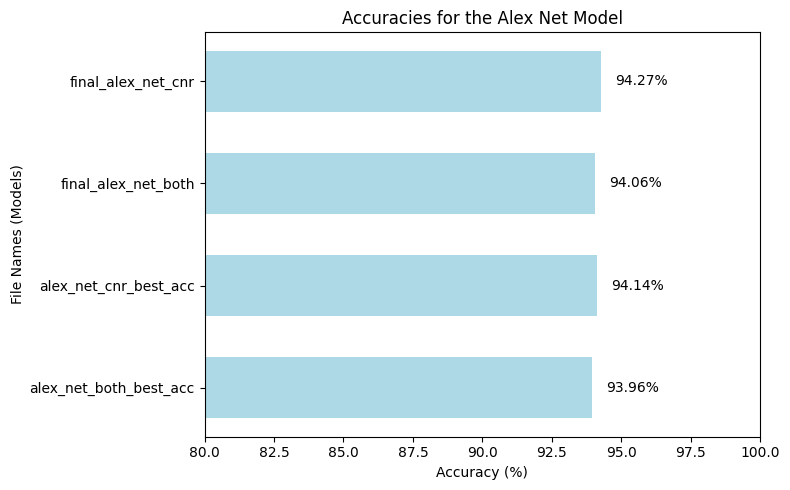

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting file names and accuracies from the dictionary
# Extracting file names and accuracies from the dictionary
file_names = list(alex_accuracies.keys())
accuracy_values = list(alex_accuracies.values())
accuracy_values = [round(value, 2) for value in accuracy_values]


# Plotting the horizontal bar graph with slimmer bars and pale blue color
plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
bars = plt.barh(file_names, accuracy_values, color='lightblue', height=0.6)  # Adjust height for slimmer bars

# Adding labels and title
plt.xlabel('Accuracy (%)')
plt.ylabel('File Names (Models)')
plt.title('Accuracies for the Alex Net Model')

# Adjust the x-axis limits to start from 80%
plt.xlim(80, 100)

# Displaying the numerical values on the bars
for bar, value in zip(bars, accuracy_values):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{value}%', va='center', fontsize=10)

# Display the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

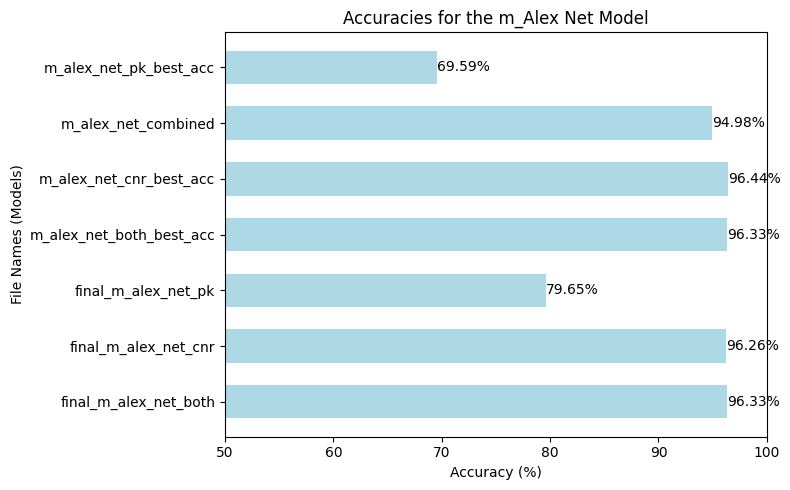

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting file names and accuracies from the dictionary
# Extracting file names and accuracies from the dictionary
file_names = list(m_alex_accuracies.keys())
accuracy_values = list(m_alex_accuracies.values())
accuracy_values = [round(value, 2) for value in accuracy_values]


# Plotting the horizontal bar graph with slimmer bars and pale blue color
plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
bars = plt.barh(file_names, accuracy_values, color='lightblue', height=0.6)  # Adjust height for slimmer bars

# Adding labels and title
plt.xlabel('Accuracy (%)')
plt.ylabel('File Names (Models)')
plt.title('Accuracies for the m_Alex Net Model')

# Adjust the x-axis limits to start from 80%
plt.xlim(50, 100)

# Displaying the numerical values on the bars
for bar, value in zip(bars, accuracy_values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{value}%', va='center', fontsize=10)

# Display the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()